In [1]:
import ast
import codecs
import json
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense, InputLayer, Embedding, Activation, LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
tagged_sentences = codecs.open("data.txt", encoding="utf-8").readlines()

In [3]:
print(tagged_sentences[0])
print("Tagged sentences: ", len(tagged_sentences))

[('’', 'PN'), ('میرے', 'G'), ('بھائی', 'NN'), ('کا', 'P'), ('ای', 'PN'), ('میل', 'U'), ('آیاہے', 'VB'), ('۔', 'SM')]

Tagged sentences:  36314


In [4]:
sentences, sentence_tags = [], []
for tagged_sentence in tagged_sentences:
    sentence, tags = zip(*ast.literal_eval(tagged_sentence))
    sentences.append(np.array(sentence))
    sentence_tags.append(np.array(tags))

In [5]:
(train_sentences,
 test_sentences,
 train_tags,
 test_tags) = train_test_split(sentences, sentence_tags, test_size=0.2)

In [6]:
def get_words(sentences):
    words = set([])
    for sentence in sentences:
        for word in sentence:
            words.add(word)
    return words

In [7]:
def get_tags(sentences_tags):
    tags = set([])
    for tag in sentences_tags:
        for t in tag:
            tags.add(t)
    return tags

In [8]:
words = get_words(sentences)
tags = get_tags(sentence_tags)

In [9]:
word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0
word2index['-OOV-'] = 1

In [10]:
tag2index = {t: i + 1 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0

In [11]:
def get_train_sentences_x(train_sentences, word2index):
    train_sentences_x = []
    for sentence in train_sentences:
        sentence_index = []
        for word in sentence:
            try:
                sentence_index.append(word2index[word])
            except KeyError:
                sentence_index.append(word2index['-OOV-'])

        train_sentences_x.append(sentence_index)
    return train_sentences_x

In [12]:
def get_test_sentences_x(test_sentences, word2index):
    test_sentences_x = []
    for sentence in test_sentences:
        sentence_index = []
        for word in sentence:
            try:
                sentence_index.append(word2index[word])
            except KeyError:
                sentence_index.append(word2index['-OOV-'])
        test_sentences_x.append(sentence_index)
    return test_sentences_x


In [13]:
train_sentences_x = get_train_sentences_x(train_sentences, word2index)
test_sentences_x = get_test_sentences_x(test_sentences, word2index)

In [14]:
def get_train_tags_y(train_tags, tag2index):
    train_tags_y = []
    for tags in train_tags:
        train_tags_y.append([tag2index[t] for t in tags])
    return train_tags_y

In [15]:
def get_test_tags_y(test_tags, tag2index):
    test_tags_y = []
    for tags in test_tags:
        test_tags_y.append([tag2index[t] for t in tags])
    return test_tags_y

In [16]:
train_tags_y = get_train_tags_y(train_tags, tag2index)
test_tags_y = get_test_tags_y(test_tags, tag2index)

In [17]:
MAX_LENGTH = len(max(train_sentences_x, key=len))

In [18]:
train_sentences_x = pad_sequences(train_sentences_x, maxlen=MAX_LENGTH, padding='post')
test_sentences_x = pad_sequences(test_sentences_x, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')

In [19]:
model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH,)))
model.add(Embedding(len(word2index), 128))
model.add(LSTM(128, return_sequences=True))
model.add(Dense(len(tag2index)))
model.add(Activation('softmax'))

In [21]:
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])
history = model.fit(train_sentences_x, to_categorical(train_tags_y, len(tag2index)), batch_size=32, epochs=10,
                    validation_split=0.2).history
model.save("/home/ranarehanqaisar/Desktop/ner.h5")
model.summary()

Epoch 1/10
727/727 [==============================] - 495s 677ms/step - loss: 0.2821 - accuracy: 0.9380 - val_loss: 0.1060 - val_accuracy: 0.9732
Epoch 2/10
727/727 [==============================] - 484s 666ms/step - loss: 0.0551 - accuracy: 0.9859 - val_loss: 0.0344 - val_accuracy: 0.9899
Epoch 3/10
727/727 [==============================] - 485s 667ms/step - loss: 0.0238 - accuracy: 0.9923 - val_loss: 0.0283 - val_accuracy: 0.9905
Epoch 4/10
727/727 [==============================] - 485s 667ms/step - loss: 0.0183 - accuracy: 0.9933 - val_loss: 0.0267 - val_accuracy: 0.9910
Epoch 5/10
727/727 [==============================] - 485s 666ms/step - loss: 0.0160 - accuracy: 0.9939 - val_loss: 0.0265 - val_accuracy: 0.9910
Epoch 6/10
727/727 [==============================] - 486s 669ms/step - loss: 0.0144 - accuracy: 0.9944 - val_loss: 0.0273 - val_accuracy: 0.9909
Epoch 7/10
727/727 [==============================] - 485s 668ms/step - loss: 0.0131 - accuracy: 0.9949 - val_loss: 0.0280 -

# Testing

In [25]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])

        token_sequences.append(token_sequence)

    return token_sequences

In [29]:
scores = model.evaluate(test_sentences_x, to_categorical(test_tags_y, len(tag2index)))
print(f"{model.metrics_names[1]}: {scores[1] * 100}")  # acc: 98.39311069478103
print(test_sentences[0])
print(test_tags[0])
test_samples = [
    test_sentences[0],
]

test_samples_x = []
for sentence in test_samples:
    sentence_index = []
    for word in sentence:
        try:
            sentence_index.append(word2index[word])
        except KeyError:
            sentence_index.append(word2index['-OOV-'])
    test_samples_x.append(sentence_index)

test_samples_X = pad_sequences(test_samples_x, maxlen=MAX_LENGTH, padding='post')
predictions = model.predict(test_samples_X)

print(logits_to_tokens(predictions, {i: t for t, i in tag2index.items()}))

227/227 [==============================] - 46s 205ms/step - loss: 0.0329 - accuracy: 0.9903
accuracy: 99.02822375297546
['یہ' 'آج' 'علی' 'کیوں' 'نہیں' 'آیا' 'ہماری' 'طرف' 'سے' 'اور' 'زیادہ'
 'آداب' 'و' 'سلام' '(' 'احمق' 'پھپھوندوی' ')' 'فرحان' 'دانش' 'نے' "'"
 'موبائل' 'کمیونیکیشن' "'" 'کی' 'ذیل' 'میں' 'اس' 'موضوع' 'کا' 'آغاز' 'کیا'
 '،' 'دسمبر' '3' ',' '2007' 'اب' 'دوبارہ' 'مٹی' 'پاؤ' 'گے' 'تو' 'ظالمو'
 'کیا' 'بناؤ' 'گے' '۔']
['PD' 'NN' 'NN' 'QW' 'NEG' 'VB' 'G' 'NN' 'SE' 'CC' 'ADV' 'NN' 'CC' 'NN'
 'PN' 'PN' 'PN' 'PN' 'PN' 'PN' 'P' 'SC' 'NN' 'PN' 'SC' 'P' 'NN' 'P' 'PD'
 'NN' 'P' 'NN' 'VB' 'PM' 'PN' 'CA' 'PM' 'CA' 'AP' 'ADV' 'NN' 'VB' 'VB'
 'SC' 'NN' 'KP' 'VB' 'TA' 'SM']
1/1 [==============================] - 0s 38ms/step
[['PP', 'NN', 'NN', 'QW', 'NEG', 'VB', 'G', 'NN', 'SE', 'CC', 'ADV', 'ADJ', 'CC', 'NN', 'PN', 'PN', 'PN', 'PN', 'PN', 'PN', 'P', 'SC', 'NN', 'PN', 'SC', 'P', 'NN', 'P', 'PD', 'NN', 'P', 'NN', 'VB', 'PM', 'PN', 'CA', 'PM', 'CA', 'AP', 'ADV', 'NN', 'NN', 'TA', 'SC', 'PN'

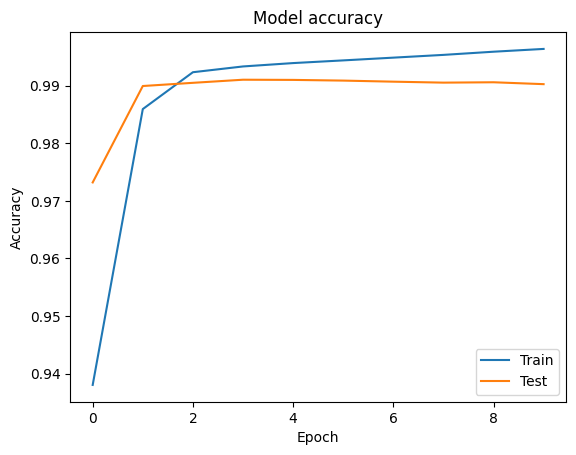

In [31]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')


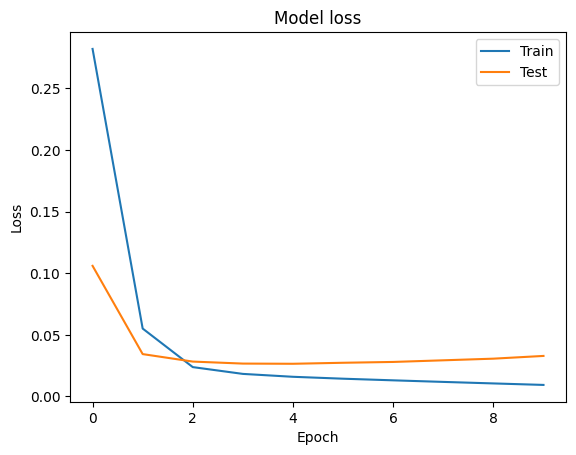

In [32]:
plt.clf()

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')